In [2]:
from typing import Optional
import random
import numpy as np
import matplotlib.pyplot as plt


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)


def assign_neighbors_to_agents(agent_list, density, domain_size, problem_type='random'):
    num_agents = len(agent_list)

    for i in range(num_agents):
        for j in range(i + 1, num_agents):
            if random.random() < density:
                a_id = agent_list[i].get_id()
                b_id = agent_list[j].get_id()

                # create cost matrix according to problem type
                if problem_type == 'random':
                    matrix = np.random.randint(100, 201, size=(domain_size, domain_size))

                elif problem_type == 'graph_coloring':
                    matrix = np.zeros((domain_size, domain_size), dtype=int)
                    for x in range(domain_size):
                        for y in range(domain_size):
                            if x == y:
                                matrix[x][y] = random.randint(100, 201)
                            else:
                                matrix[x][y] = 0

                agent_list[i].add_neighbor(b_id, matrix)
                agent_list[j].add_neighbor(a_id, matrix.T)



class Message:

    def __init__(self, sender, receiver_id, value):
        self.sender_id = sender.get_id() # to maintain privacy of the sending agent when the message is delivered
        self.receiver_id = receiver_id # the sending agent only has access to the its neighbor's id
        self.value = value # the current assigned value of the agent's variable

        # no need to validate credibilty of message since the agent iterates through its neighbors


    def get_id(self, type_of_id):
        """
        type_of_id can be either "sender" or "receiver"
        """
        if type_of_id == "sender":
            return self.sender_id
        elif type_of_id == "receiver":
            return self.receiver_id



class Mailperson:

    def __init__(self, agents):

        self.agent_dict = {agent.id: agent for agent in agents}  # id → Agent object
        self.mail_out = {agent: [] for agent in agents} # Agent object → messages to deliver to agent


    def receive_messages(self):
      """
      Collects messages from each agent’s mailbox and groups
      them by their intended receiver in the mail_out dictionary.
      after processing, it clears the sender agents’ mailboxes.
      """

      agents = self.agent_dict.values()

      for agent in agents:
          for message in agent.send_mailbox:  # iterating over the agent's mailbox
              receiver = self.agent_dict[message.get_id("receiver")]
              self.mail_out[receiver].append(message)

          # Empty the mailbox after processing all messages
          agent.send_mailbox.clear()



    def deliver_messages(self):
      """
      Delivers the collected messages from mail_out to each receiving
      agent and then clears their message lists in mail_out.
      """

      agents = self.agent_dict.values()

      for agent in agents:
          messages_to_deliver = self.mail_out[agent]
          agent.receive_messages(messages_to_deliver)
          self.mail_out[agent].clear()




class Agent:
    def __init__(self, id, domain):
        self.id = id
        self.domain = domain
        random_index = random.randint(0, len(domain) - 1)
        self.value = domain[random_index]
        self.cost_tables = {}
        self.receive_mailbox = []
        self.send_mailbox = []
        self.neighbors = []
        self.neighbor_values = {}
        self.cost = 10000 #begin from very big number

    def get_id(self):
        return self.id

    def get_mailbox(self):
        return self.mailbox

    def add_neighbor(self, neighbor_id, cost_matrix):
        if neighbor_id not in self.neighbors:
            self.neighbors.append(neighbor_id)
            self.cost_tables[neighbor_id] = cost_matrix


    def receive_messages(self, messages):
        self.receive_mailbox.extend(messages)

    def send_messages(self):
        for neighbor_id in self.neighbors:
            self.send_mailbox.append(Message(self, neighbor_id ,self.value))


    def calculate_cost(self, value, neighbor_values, cost_tables):
        cost = 0
        for neighbor_id, neighbor_val in neighbor_values.items():
            cost_matrix = cost_tables.get(neighbor_id)
            cost += cost_matrix[value][neighbor_val]

        return cost

    #check my best assignment according my neighbors values
    def evaluate_better_assignment(self):
        current_cost = self.calculate_cost(self.value, self.neighbor_values, self.cost_tables)
        best_value = self.value
        best_cost = current_cost

        for val in self.domain:
            if val == self.value:
                continue
            alt_cost = self.calculate_cost(val, self.neighbor_values, self.cost_tables)
            if alt_cost < best_cost:
                best_value = val
                best_cost = alt_cost

        return best_value, best_cost



class DSA_Agent(Agent):

    def __init__(self, id, domain):
        super().__init__(id, domain)
        self.improvement = 0
        self.best_value = self.value


    def update_better_assignment(self,p):
        self.neighbor_values = {
        msg.get_id("sender"): msg.value
        for msg in self.receive_mailbox
        }
        self.receive_mailbox.clear()

        best_value,best_cost = self.evaluate_better_assignment()
        if best_value != self.value and random.random() < p:
            self.value = best_value
            self.cost = best_cost



class MGM_Agent(Agent):

    def __init__(self, id, domain):
        super().__init__(id, domain)
        self.improvement = 0
        self.best_value = self.value
        self.best_cost = self.cost

    #get value from neighbor and check my improvement
    def check_best_assignment(self):
        self.neighbor_values = {
        msg.get_id("sender"): msg.value
        for msg in self.receive_mailbox
        }
        self.send_best_assignment()
        self.receive_mailbox.clear()

    def send_best_assignment(self):
        best_value, best_cost = self.evaluate_better_assignment()
        self.best_value = best_value
        self.best_cost = best_cost
        self.improvement = self.cost - best_cost

        self.send_improvement()


    def send_improvement(self):
        for neighbor_id in self.neighbors:
            self.send_mailbox.append(Message(self, neighbor_id, self.improvement))


    #if my improve is the best- update
    def update_better_assignment(self):
        if self.improvement <= 0:
            return

        neighbor_improvement = {
        msg.get_id("sender"): msg.value
        for msg in self.receive_mailbox
        }
        self.receive_mailbox.clear()

        for sender_id,gain in neighbor_improvement.items():
            if gain > self.improvement:
                return
            if gain == self.improvement and sender_id < self.id:
                return

        self.value = self.best_value
        self.cost = self.best_cost



class MGM2_Agent(MGM_Agent):
    def __init__(self, id, domain):
        super().__init__(id, domain)
        self.proposer = 0 #proposer-1, receiver - 0
        self.my_couple = None
        self.i_am_winner = False

    #if I proposer- choise random neighbor and send him evetything (all my neighbors values and table cost)
    def random_proposer(self):
        self.neighbor_values = {
        msg.get_id("sender"): msg.value
        for msg in self.receive_mailbox
        }
        self.receive_mailbox.clear()

        self.proposer = random.randint(0,1)
        if self.proposer == 1 and self.neighbors:
            random_neighbor = random.choice(self.neighbors)
            self.send_mailbox.append(Message(self, random_neighbor ,(self.value,self.neighbor_values,self.cost_tables)))


    #if I receiver- choise random proposal and calculate the shared assignment
    def select_proposal(self):
        if self.proposer == 0:
          if self.receive_mailbox:
              chosen_msg = random.choice(self.receive_mailbox)

              neighbor_id = chosen_msg.get_id("sender")
              self.my_couple = neighbor_id

              neighbor_value, neighbor_value_neighbors, neighbor_cost_tables = chosen_msg.value
              self.receive_mailbox.clear()

              #send my choise neighbor values to check the shared assignment
              self.send_best_assignment_shared(neighbor_id, neighbor_value, neighbor_value_neighbors, neighbor_cost_tables)

        else:
            self.receive_mailbox.clear()

    #check our best improve and send to the proposer neighbor
    def send_best_assignment_shared(self, neighbor_id, neighbor_value,neighbor_value_neighbors, neighbor_cost_tables):


        shared_cost = (self.calculate_cost(self.value,self.neighbor_values, self.cost_tables) +
                      self.calculate_cost(neighbor_value,neighbor_value_neighbors, neighbor_cost_tables) -
                      self.cost_tables[neighbor_id][self.value][neighbor_value])

        improvement_shared_cost = 0
        best_neighbor_val = neighbor_value
        for val in self.domain:
            for val2 in self.domain:
                temp_shared_cost = (self.calculate_cost(val,self.neighbor_values, self.cost_tables) +
                        self.calculate_cost(val2 ,neighbor_value_neighbors, neighbor_cost_tables) -
                        self.cost_tables[neighbor_id][val][val2])
                temp_improvement = shared_cost - temp_shared_cost
                if  improvement_shared_cost < temp_improvement:
                    improvement_shared_cost = temp_improvement
                    self.best_value = val
                    best_neighbor_val = val2

        self.improvement = improvement_shared_cost
        self.send_mailbox.append(Message(self, neighbor_id, (self.improvement, best_neighbor_val)))

    #if I proposer and my receiver choose me- update our shared improve
    def get_best_assignment_shared(self):
        if self.receive_mailbox:
            msg = random.choice(self.receive_mailbox)

            improvement, best_val= msg.value

            self.improvement = improvement
            self.best_value = best_val
            self.my_couple = msg.get_id("sender")

        self.receive_mailbox.clear()

        self.send_improvement()

    #check if i win- and not update (because my neighbor also need to win, if i am in couple)
    def check_winner(self):
        neighbor_improvement = {
            msg.get_id("sender"): msg.value
            for msg in self.receive_mailbox}

        self.receive_mailbox.clear()

        self.i_am_winner = True

        for sender_id, gain in neighbor_improvement.items():
            if gain > self.improvement:
                self.i_am_winner = False
                break
            if gain == self.improvement and (not sender_id == self.my_couple):
                self.i_am_winner = False
                break

        if self.my_couple is not None:
            self.send_mailbox.append(Message(self, self.my_couple, self.i_am_winner))

    #if i alone- if i win- apdate, couple- if both win- update
    def update_winner(self):
        if self.i_am_winner and self.improvement > 0:
            if self.my_couple is not None and self.receive_mailbox:
              msg = self.receive_mailbox[0]
              if msg.value is True:
                  self.value = self.best_value
                  self.cost = self.best_cost

            else:
                self.value = self.best_value
                self.cost = self.best_cost
        self.my_couple = None



def calculate_global_cost(agent_list):
    total_cost = 0
    for agent in agent_list:
        for neighbor_id in agent.neighbors:
            neighbor_value = next(a.value for a in agent_list if a.id == neighbor_id)
            cost_matrix = agent.cost_tables[neighbor_id]
            total_cost += cost_matrix[agent.value][neighbor_value]
    return total_cost // 2


def run_multiple_simulations(runs=30, iterations=50, algo = 'dsa', p = 1):
    all_runs = []
    for seed in range(runs):
        if algo == 'dsa':
            costs = run_dsa_simulation(p=p, seed=seed, iterations=iterations)
        if algo == 'mgm':
            costs = run_mgm_simulation(seed=seed, iterations=iterations)
        all_runs.append(costs)
    return np.array(all_runs)



In [3]:
#DSA algorithm
def run_dsa_simulation(num_agents=30, domain_size=5, density=0.25, p=0.7, seed=42, iterations=50, problem_type = 'random'):
    set_seed(seed)
    domain = list(range(domain_size))
    agents = [DSA_Agent(id=i, domain=domain) for i in range(num_agents)]
    assign_neighbors_to_agents(agents, density, domain_size, problem_type)
    global_costs = []
    mail_woman = Mailperson(agents)

    for agent in agents:
        agent.send_messages()


    for it in range(iterations):

        cost = calculate_global_cost(agents)
        global_costs.append(cost)

        mail_woman.receive_messages()
        mail_woman.deliver_messages()

         #update assignment
        for agent in agents:
            agent.update_better_assignment(p)
            agent.send_messages()


    return global_costs

In [4]:
def run_mgm_simulation(num_agents=30, domain_size=5, density=0.25, seed=42, iterations=50, problem_type = 'random'):
    set_seed(seed)
    domain = list(range(domain_size))
    agents = [MGM_Agent(id=i, domain=domain) for i in range(num_agents)]
    assign_neighbors_to_agents(agents, density, domain_size, problem_type)
    global_costs = []
    mail_woman = Mailperson(agents)

    cost = calculate_global_cost(agents)
    global_costs.append(cost)

    for it in range(1,iterations+1):
        if it % 2 == 1:
            for agent in agents:
                agent.send_messages()

            mail_woman.receive_messages()
            mail_woman.deliver_messages()

            #Step 1: Each agent calculates its best improvement and sends it to its neighbors
            for agent in agents:
                agent.check_best_assignment()

            cost = calculate_global_cost(agents)
            global_costs.append(cost)

        if it % 2 == 0:

            mail_woman.receive_messages()
            mail_woman.deliver_messages()

            #Step 2: Each agent checks if it is the one that should update (i.e., the best in its neighborhood)
            for agent in agents:
                agent.update_better_assignment()

            cost = calculate_global_cost(agents)
            global_costs.append(cost)

    return global_costs


In [5]:
def run_mgm2_simulation(num_agents=30, domain_size=5, density=0.25, seed=42, iterations=50, problem_type = 'random'):
    set_seed(seed)
    domain = list(range(domain_size))
    agents = [MGM2_Agent(id=i, domain=domain) for i in range(num_agents)]
    assign_neighbors_to_agents(agents, density, domain_size, problem_type)
    mail_woman = Mailperson(agents)
    global_costs = []

    for agent in agents:
        agent.send_messages()

    mail_woman.receive_messages()
    mail_woman.deliver_messages()

    cost = calculate_global_cost(agents)
    global_costs.append(cost)

    for it in range(1, iterations+1):

        #Iteration 1 – Randomly selected proposers and sent their proposals and information
        if it % 5 == 1:

            for agent in agents:
                agent.random_proposer()

            mail_woman.receive_messages()
            mail_woman.deliver_messages()

            cost = calculate_global_cost(agents)
            global_costs.append(cost)

        #Iteration 2 – Proposal selection and calculation of the optimal joint proposal
        if it % 5 == 2:

            for agent in agents:
                agent.select_proposal()

            mail_woman.receive_messages()
            mail_woman.deliver_messages()

            cost = calculate_global_cost(agents)
            global_costs.append(cost)

        #Iteration 3 – Agents send their LR based on even/odd assignment
        if it % 5 == 3:

            for agent in agents:
                if agent.proposer == 1 and agent.my_couple is not None:
                    agent.get_best_assignment_shared()

                if agent.proposer == 0 and agent.my_couple is not None:
                    agent.send_improvement()

                if agent.my_couple == None:
                    agent.send_best_assignment()

            mail_woman.receive_messages()
            mail_woman.deliver_messages()

            cost = calculate_global_cost(agents)
            global_costs.append(cost)

        #Iteration 4- Each agent send to the neighbor if he win
        if it % 5 == 4:

            for agent in agents:
                agent.check_winner()

            mail_woman.receive_messages()
            mail_woman.deliver_messages()

            cost = calculate_global_cost(agents)
            global_costs.append(cost)

        #Iteration 5- update winner
        if it % 5 == 0:
            for agent in agents:
                agent.update_winner()
                agent.send_messages()

            mail_woman.receive_messages()
            mail_woman.deliver_messages()

            cost = calculate_global_cost(agents)
            global_costs.append(cost)

    return global_costs


def run_multiple_simulations_mgm2(runs=30, iterations=50, num_agents=30, domain_size=5, density=0.25):
    all_runs = []
    for seed in range(runs):
        costs = run_mgm2_simulation(
            num_agents=num_agents,
            domain_size=domain_size,
            density=density,
            seed=seed,
            iterations=iterations
        )
        all_runs.append(costs)
    return np.array(all_runs)

In [6]:
def run_multiple_simulations(runs=30, iterations=100, algo='dsa', p=0.7,
                             num_agents=30, domain_size=5, density=0.25, problem_type = 'random'):
    all_costs = []
    for seed in range(runs):
        if algo == 'dsa':
            costs = run_dsa_simulation(num_agents=num_agents,
                                       domain_size=domain_size,
                                       density=density,
                                       p=p,
                                       seed=seed,
                                       iterations=iterations,
                                       problem_type=problem_type)
        elif algo == 'mgm':
            costs = run_mgm_simulation(num_agents=num_agents,
                                       domain_size=domain_size,
                                       density=density,
                                       seed=seed,
                                       iterations=iterations,
                                       problem_type=problem_type)
        elif algo == 'mgm2':
            costs = run_mgm2_simulation(num_agents=num_agents,
                                        domain_size=domain_size,
                                        density=density,
                                        seed=seed,
                                        iterations=iterations,
                                        problem_type=problem_type)
        else:
            raise ValueError("Unsupported algorithm")
        all_costs.append(costs)
    return np.array(all_costs)

def plot_all_algorithms_on_same_graph(runs=30, iterations=100, density=0.25, domain_size=5, problem_type = 'random'):
    plt.figure(figsize=(12, 6))

    # DSA with p=0.2, 0.7, 1.0
    for p in [0.2, 0.7, 1.0]:
        dsa_costs = run_multiple_simulations(runs=runs, iterations=iterations, algo='dsa', p=p, density=density, problem_type=problem_type)
        avg_dsa = dsa_costs.mean(axis=0)
        plt.plot(avg_dsa, label=f"DSA (p={p})")

    # MGM
    mgm_costs = run_multiple_simulations(runs=runs, iterations=iterations, algo='mgm', density=density, problem_type=problem_type)
    avg_mgm = mgm_costs.mean(axis=0)
    plt.plot(avg_mgm, label="MGM")

    # MGM-2
    mgm2_costs = run_multiple_simulations(runs=runs, iterations=iterations, algo='mgm2', density=density, problem_type=problem_type)
    avg_mgm2 = mgm2_costs.mean(axis=0)
    plt.plot(avg_mgm2, label="MGM-2")

    plt.xlabel("Iteration")
    plt.ylabel("Average Global Cost")
    plt.title(f"Comparison of Algorithms (Density K={density})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

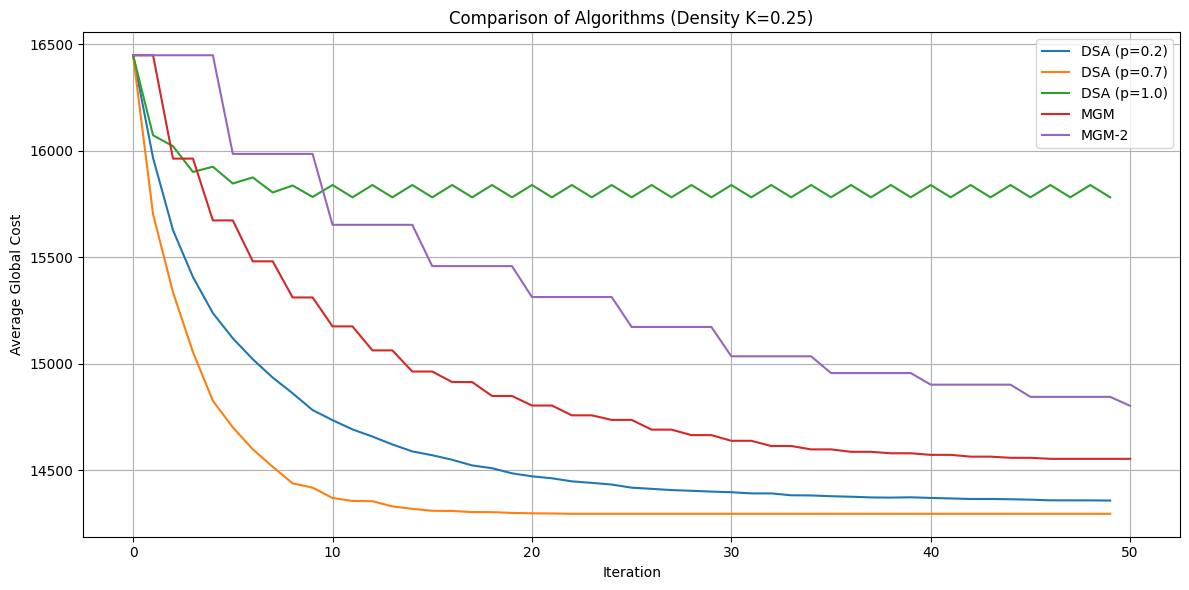

In [7]:
#K = 0.25
plot_all_algorithms_on_same_graph(runs=30, iterations=50, density=0.25)

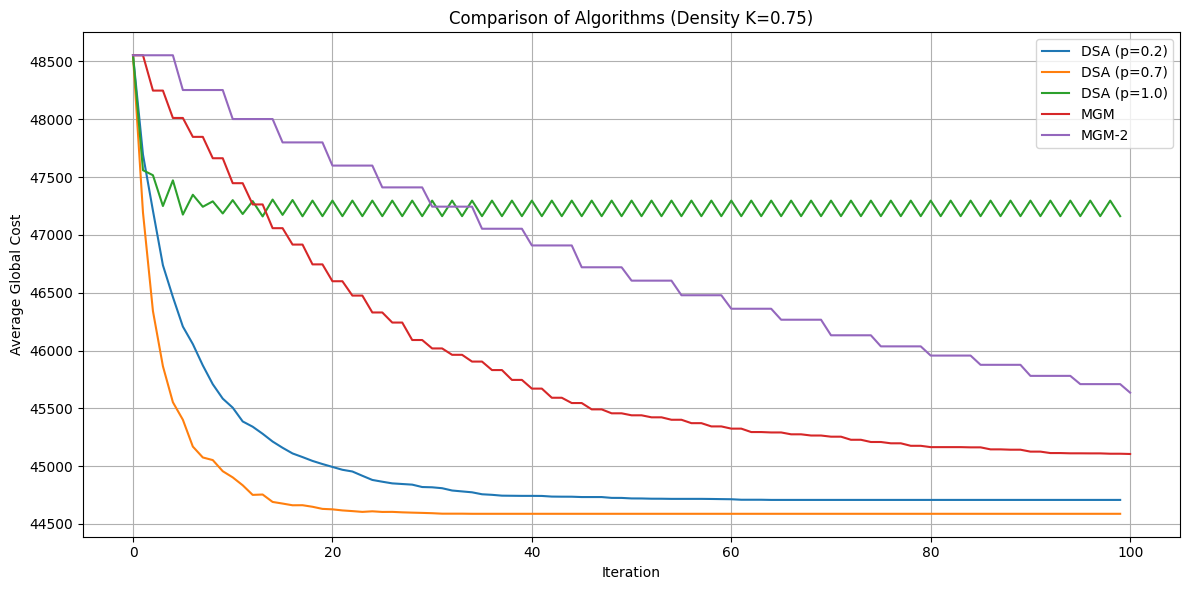

In [8]:
#K = 0.75
plot_all_algorithms_on_same_graph(runs=30, iterations=100, density=0.75)

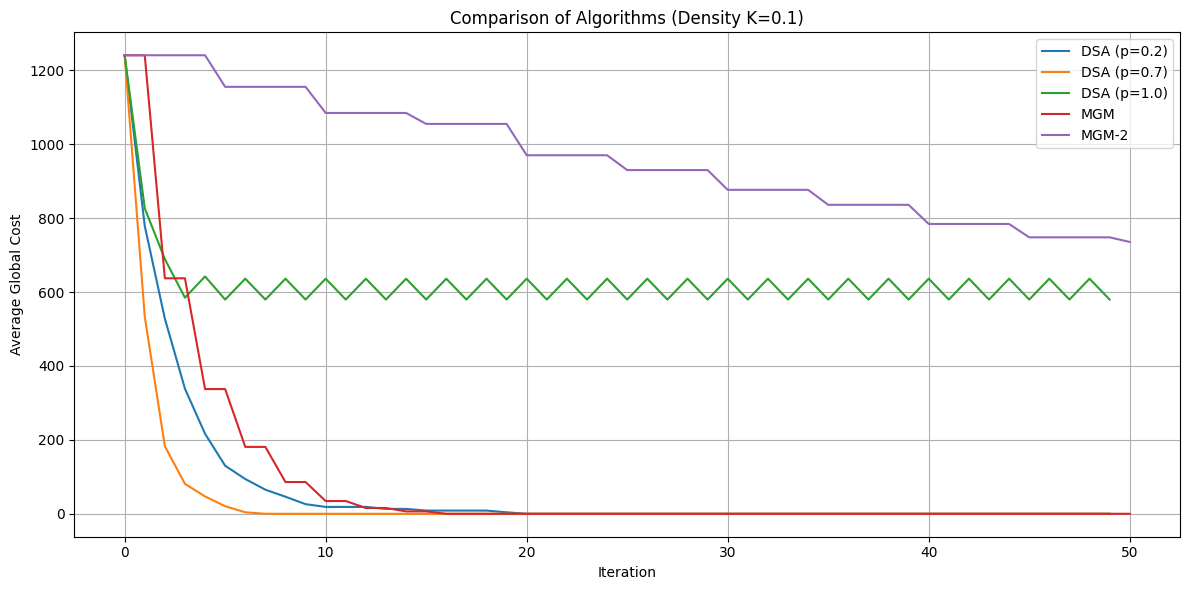

In [9]:
#graph coloring
plot_all_algorithms_on_same_graph(runs=30, iterations=50, density=0.1,domain_size=3, problem_type = 'graph_coloring')